In [1]:
import pandas as pd
import sys
sys.path.append('../src')
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
from scipy.stats import ttest_ind


df_clients_profile = pd.read_csv('../Data/raw/df_final_demo.txt')
df_web_data_1 = pd.read_csv('../Data/raw/df_final_web_data_pt_1.txt')
df_web_data_2 = pd.read_csv('../Data/raw/df_final_web_data_pt_2.txt')
df_experiment_clients = pd.read_csv('../Data/raw/df_final_experiment_clients.txt')
pd.set_option('display.max_columns', None)
df_web_data = pd.concat([df_web_data_1, df_web_data_2], ignore_index= True)

## Drop duplicates values

In [2]:
#clean df_clients_profile
df_clients_profile = print_clean_data(df_clients_profile)

Before
client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64
------------------------------------------
------------------------------------------
After
client_id           0
clnt_tenure_yr      0
clnt_tenure_mnth    0
clnt_age            0
gendr               0
num_accts           0
bal                 0
calls_6_mnth        0
logons_6_mnth       0
dtype: int64


In [3]:
#clean df_experiment_clients
df_experiment_clients = print_clean_data(df_experiment_clients)

Before
client_id        0
Variation    20109
dtype: int64
------------------------------------------
To many NaN values in column: Variation
------------------------------------------
After
client_id        0
Variation    20109
dtype: int64


In [4]:
#clean df_web_data
df_web_data = print_clean_data(df_web_data)

Before
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64
------------------------------------------
------------------------------------------
After
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


In [5]:
df_web_data.head(20)

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
5,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15
6,9988021,580560515_7732621733,781255054_21935453173_531117,step_1,2017-04-17 15:17:01
7,9988021,580560515_7732621733,781255054_21935453173_531117,start,2017-04-17 15:16:22
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43


## Create a data frame with the clients that won't participe in the experiment.

In [6]:
#setting aside the clients that wont be part if the experiment
null_df_experiment_clients = df_experiment_clients[df_experiment_clients['Variation'].isnull()]
null_df_experiment_clients

,client_id,Variation
50500,5459747,NaN
50501,8031000,NaN
50502,1847030,NaN
50503,9713157,NaN
50504,7775828,NaN
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


## Merge the clients in the web data

### Identify the clients part of the test group

In [7]:
#id of clients that are part of the test
df_experiment_clients_Test = df_experiment_clients[df_experiment_clients['Variation'] == 'Test']
df_experiment_clients_Test.head(10)

,client_id,Variation
0,9988021,Test
1,8320017,Test
3,1982004,Test
5,9466803,Test
6,3170143,Test
8,5887227,Test
10,438567,Test
11,2519971,Test
13,5407849,Test
16,5308474,Test


### df_test: combine visit_id with visitor_id and reoganize the columns.

In [8]:
final_df_Test = pd.merge(df_experiment_clients_Test, df_clients_profile, on='client_id', how='inner')
final_df_Test = pd.merge(df_web_data, final_df_Test, on='client_id', how='inner')
df_test = final_df_Test

df_test.head(15)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
5,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
6,9988021,580560515_7732621733,781255054_21935453173_531117,step_1,2017-04-17 15:17:01,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
7,9988021,580560515_7732621733,781255054_21935453173_531117,start,2017-04-17 15:16:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0


### df_control: combine visit_id with visitor_id and reoganize the columns.

In [9]:
#id of clients that are part of the control group
df_experiment_clients_Control = df_experiment_clients[df_experiment_clients['Variation'] == 'Control']
df_experiment_clients_Control.head(10)

,client_id,Variation
2,4033851,Control
4,9294070,Control
7,6651403,Control
9,2105948,Control
12,9814849,Control
14,7286739,Control
15,4446011,Control
20,4229407,Control
24,2842481,Control
27,1218661,Control


In [10]:
df_experiment_clients_Control = df_experiment_clients[df_experiment_clients['Variation'] == 'Control']
final_df_Control = pd.merge(df_experiment_clients_Control, df_clients_profile, on='client_id', how='inner')
final_df_Control = pd.merge(df_web_data, final_df_Control, on='client_id', how='inner')
df_control = final_df_Control
df_control.head(20)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:03,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
1,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:01,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
2,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:28:52,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
3,4033851,762728880_76361333336,949661017_22392791362_127391,step_3,2017-04-05 12:26:08,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
4,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:24:43,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
5,4033851,762728880_76361333336,949661017_22392791362_127391,step_1,2017-04-05 12:24:12,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
6,4033851,762728880_76361333336,949661017_22392791362_127391,start,2017-04-05 12:24:04,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
7,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:10:26,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
8,4033851,762728880_76361333336,949661017_22392791362_127391,step_3,2017-04-05 12:10:26,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
9,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:10:25,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0


## Pivot and create new columns

### df_test

In [11]:
df_test

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177782,1574008,117364417_77840596075,528720790_71583064618_169151,confirm,2017-05-06 23:51:05,Test,10.0,121.0,55.0,U,2.0,153238.83,3.0,6.0
177783,1574008,117364417_77840596075,528720790_71583064618_169151,step_3,2017-05-06 23:50:40,Test,10.0,121.0,55.0,U,2.0,153238.83,3.0,6.0
177784,1574008,117364417_77840596075,528720790_71583064618_169151,step_2,2017-05-06 23:43:47,Test,10.0,121.0,55.0,U,2.0,153238.83,3.0,6.0
177785,1574008,117364417_77840596075,528720790_71583064618_169151,step_1,2017-05-06 23:43:34,Test,10.0,121.0,55.0,U,2.0,153238.83,3.0,6.0


In [12]:
# Assuming df_control is your DataFrame
# 1. Data Preparation:
df_test['date_time'] = pd.to_datetime(df_test['date_time'])
df_test['date'] = df_test['date_time'].dt.date
# Combine visit_id and visitor_id into a new column
df_test['visit_visitor_id'] = df_test['visit_id'].astype(str) + "_" + df_test['visitor_id'].astype(str)

In [13]:
# 2. Calculate time differences per step and make them positive:
# We need to sort the dataframe before calculating the time difference
df_test = df_test.sort_values(by=['visit_id', 'client_id', 'date_time'])

df_test['next_date_time'] = df_test.groupby(['visit_id', 'client_id'])['date_time'].shift(-1)

# Calculate time spent in seconds, but make sure it's always positive
df_test['time_diff_seconds'] = (df_test['next_date_time'] - df_test['date_time']).dt.total_seconds()
df_test['time_diff_minutes'] = df_test['time_diff_seconds'] / 60

In [14]:
# 3. Pivot to Create Step Columns:
df_pivot = df_test.pivot_table(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='time_diff_minutes', fill_value=0, aggfunc='sum')
df_pivot = df_pivot.reset_index()
df_pivot.columns.name = None  # Remove the 'process_step' header

In [15]:
# 4. Rename Columns & Calculate Total Time:
df_pivot = df_pivot.rename(columns={'confirm': 'confirm_time', 'start': 'start_time', 'step_1': 'step_1', 'step_2': 'step_2', 'step_3': 'step_3'})

df_pivot['total_time_visit'] = df_pivot[['start_time', 'step_1', 'step_2', 'step_3', 'confirm_time']].sum(axis=1)

# 5. Merge with Original Data and Select/Reorder Columns:
final_df_t = pd.merge(df_pivot, df_test[['client_id', 'visit_id','Variation', 'clnt_tenure_yr',
       'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal',
       'calls_6_mnth', 'logons_6_mnth', 'date', 'process_step']], on=['client_id', 'visit_id'], how='left')

In [16]:
# Get last step per visit_id
final_df_t['last_step'] = final_df_t.groupby('visit_id')['process_step'].transform('last')

# Add new columns bt_1, bt_2, bt_3 for counts of step_1, step_2, step_3
step_counts = df_test.groupby(['visit_visitor_id', 'process_step']).size().unstack(fill_value=0)

# Add bt_1, bt_2, bt_3 columns to final_df
final_df_t['visit_visitor_id'] = final_df_t['visit_id'].astype(str) + "_" + final_df_t['visitor_id'].astype(str)
final_df_t['bt_1'] = final_df_t['visit_visitor_id'].map(step_counts.get('step_1', pd.Series())).fillna(0).astype(int)
final_df_t['bt_2'] = final_df_t['visit_visitor_id'].map(step_counts.get('step_2', pd.Series())).fillna(0).astype(int)
final_df_t['bt_3'] = final_df_t['visit_visitor_id'].map(step_counts.get('step_3', pd.Series())).fillna(0).astype(int)

# Create completion column
final_df_t['completion'] = final_df_t['last_step'].apply(lambda x: 1 if x == 'confirm' else 0)

# Create total_navigation column
final_df_t['total_navigation'] = final_df_t['bt_1'] + final_df_t['bt_2'] + final_df_t['bt_3']

In [17]:
# Drop visit_visitor_id column if no longer needed
final_df_t.drop(['visit_id', 'visitor_id','process_step', 'confirm_time'], axis=1, inplace=True)
final_df_t.drop_duplicates(subset='visit_visitor_id', keep='first', inplace=True)
# Reorder columns to place total_navigation after bt_3 and completed at the end
df_test_final = final_df_t.reindex(columns=[
    'client_id', 'visit_visitor_id', 'start_time', 'step_1', 'step_2', 'step_3', 
    'date', 'bt_1', 'bt_2', 'bt_3', 'total_navigation', 'last_step', 'completion',
    'total_time_visit', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth', 
    'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'
])


In [18]:
df_test_final['client_id'] = df_test_final['client_id'].astype(object)
df_test_final['visit_visitor_id'] = df_test_final['visit_visitor_id'].astype(object)
df_test_final['start_time'] = round(df_test_final['start_time'].astype(float),2)
df_test_final['step_1'] = round(df_test_final['step_1'].astype(float),2)
df_test_final['step_2'] = round(df_test_final['step_2'].astype(float),2)
df_test_final['step_3'] = round(df_test_final['step_3'].astype(float),2)
df_test_final['date'] = pd.to_datetime(df_test_final.date)
df_test_final['bt_1'] = df_test_final['bt_1'].astype(int)
df_test_final['bt_2'] = df_test_final['bt_2'].astype(int)
df_test_final['bt_3'] = df_test_final['bt_3'].astype(int)
df_test_final['total_navigation'] = df_test_final['total_navigation'].astype(int)
df_test_final['last_step'] = df_test_final['last_step'].astype(object)
df_test_final['completion'] = df_test_final['completion'].astype(bool)
df_test_final['total_time_visit'] = round(df_test_final['total_time_visit'].astype(float),2)
df_test_final['Variation'] = df_test_final['Variation'].astype(object)
df_test_final['clnt_tenure_yr'] = df_test_final['clnt_tenure_yr'].astype(int)
df_test_final['clnt_tenure_mnth'] = df_test_final['clnt_tenure_mnth'].astype(int)
df_test_final['clnt_age'] = df_test_final['clnt_age'].astype(int)
df_test_final['gendr'] = df_test_final['gendr'].astype(object)
df_test_final['num_accts'] = df_test_final['num_accts'].astype(int)
df_test_final['calls_6_mnth'] = df_test_final['calls_6_mnth'].astype(int)
df_test_final['logons_6_mnth'] = df_test_final['logons_6_mnth'].astype(int)

In [19]:
df_test_final.head(10)

,client_id,visit_visitor_id,start_time,step_1,step_2,step_3,date,bt_1,bt_2,bt_3,total_navigation,last_step,completion,total_time_visit,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,555,637149525_38041617439_716659_402506806_5608737...,0.12,0.53,1.65,0.33,2017-04-15,1,1,1,3,confirm,True,2.63,Test,3,46,29,U,2,25454.66,2,6
5,647,40369564_40101682850_311847_66758770_53988066587,0.12,0.30,3.15,2.72,2017-04-12,1,1,1,3,confirm,True,6.28,Test,12,151,57,M,2,30525.80,0,4
10,934,7076463_57954418406_971348_810392784_45004760546,2.37,0.00,0.00,0.00,2017-04-18,0,0,0,0,start,False,2.37,Test,9,109,51,F,2,32522.88,0,3
14,1336,583743392_96265099036_939815_920624746_3260333...,0.42,0.43,0.85,1.82,2017-05-08,1,1,1,3,confirm,True,3.52,Test,48,576,42,M,4,130537.18,6,9
19,1336,614001770_19101025926_112779_920624746_3260333...,0.00,0.00,0.00,0.00,2017-05-08,0,0,0,0,confirm,True,1.37,Test,48,576,42,M,4,130537.18,6,9
21,1346,27144337_83739845380_214282_123474046_4204671056,2.65,3.37,0.82,1.42,2017-06-06,2,1,2,5,step_3,False,8.25,Test,14,177,46,F,2,822512.91,3,6
31,1516,255400977_38039535960_779641_182314299_6316858...,0.93,0.58,10.12,4.27,2017-04-06,1,1,1,3,confirm,True,15.90,Test,12,150,58,F,2,25408.39,5,8
36,1516,481123290_95510977345_707323_182314299_6316858...,1.33,1.67,1.08,0.00,2017-04-05,3,3,0,6,step_1,False,4.08,Test,12,150,58,F,2,25408.39,5,8
47,1643,753205700_16851596206_134483_121807985_2052456...,1.00,0.27,9.70,0.50,2017-06-10,1,1,1,3,confirm,True,11.47,Test,19,229,55,M,2,81731.39,0,3
52,1643,379946188_1773022140_107963_910842861_51062379179,0.00,0.00,0.00,0.00,2017-04-15,0,0,0,0,start,False,0.00,Test,19,229,55,M,2,81731.39,0,3


In [20]:
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37122 entries, 0 to 177785
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         37122 non-null  object        
 1   visit_visitor_id  37122 non-null  object        
 2   start_time        37122 non-null  float64       
 3   step_1            37122 non-null  float64       
 4   step_2            37122 non-null  float64       
 5   step_3            37122 non-null  float64       
 6   date              37122 non-null  datetime64[ns]
 7   bt_1              37122 non-null  int64         
 8   bt_2              37122 non-null  int64         
 9   bt_3              37122 non-null  int64         
 10  total_navigation  37122 non-null  int64         
 11  last_step         37122 non-null  object        
 12  completion        37122 non-null  bool          
 13  total_time_visit  37122 non-null  float64       
 14  Variation         37122 no

### df_control

In [21]:
df_control.head(10)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:03,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
1,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:01,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
2,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:28:52,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
3,4033851,762728880_76361333336,949661017_22392791362_127391,step_3,2017-04-05 12:26:08,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
4,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:24:43,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
5,4033851,762728880_76361333336,949661017_22392791362_127391,step_1,2017-04-05 12:24:12,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
6,4033851,762728880_76361333336,949661017_22392791362_127391,start,2017-04-05 12:24:04,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
7,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:10:26,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
8,4033851,762728880_76361333336,949661017_22392791362_127391,step_3,2017-04-05 12:10:26,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
9,4033851,762728880_76361333336,949661017_22392791362_127391,step_2,2017-04-05 12:10:25,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0


In [22]:
# Assuming df_control is your DataFrame
# 1. Data Preparation:
df_control['date_time'] = pd.to_datetime(df_control['date_time'])
df_control['date'] = df_control['date_time'].dt.date
# Combine visit_id and visitor_id into a new column
df_control['visit_visitor_id'] = df_control['visit_id'].astype(str) + "_" + df_control['visitor_id'].astype(str)

In [23]:
# 2. Calculate time differences per step and make them positive:
# We need to sort the dataframe before calculating the time difference
df_control = df_control.sort_values(by=['visit_id', 'client_id', 'date_time'])

df_control['next_date_time'] = df_control.groupby(['visit_id', 'client_id'])['date_time'].shift(-1)

# Calculate time spent in seconds, but make sure it's always positive
df_control['time_diff_seconds'] = (df_control['next_date_time'] - df_control['date_time']).dt.total_seconds()
df_control['time_diff_minutes'] = df_control['time_diff_seconds'] / 60

In [24]:
# 3. Pivot to Create Step Columns:
df_pivot = df_control.pivot_table(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='time_diff_minutes', fill_value=0, aggfunc='sum')
df_pivot = df_pivot.reset_index()
df_pivot.columns.name = None  # Remove the 'process_step' header

In [25]:
# 4. Rename Columns & Calculate Total Time:
df_pivot = df_pivot.rename(columns={'confirm': 'confirm_time', 'start': 'start_time', 'step_1': 'step_1', 'step_2': 'step_2', 'step_3': 'step_3'})

df_pivot['total_time_visit'] = df_pivot[['start_time', 'step_1', 'step_2', 'step_3', 'confirm_time']].sum(axis=1)

# 5. Merge with Original Data and Select/Reorder Columns:
final_df_c = pd.merge(df_pivot, df_control[['client_id', 'visit_id','Variation', 'clnt_tenure_yr',
       'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal',
       'calls_6_mnth', 'logons_6_mnth', 'date', 'process_step']], on=['client_id', 'visit_id'], how='left')

In [26]:
# Get last step per visit_id
final_df_c['last_step'] = final_df_c.groupby('visit_id')['process_step'].transform('last')

# Add new columns bt_1, bt_2, bt_3 for counts of step_1, step_2, step_3
step_counts = df_control.groupby(['visit_visitor_id', 'process_step']).size().unstack(fill_value=0)

# Add bt_1, bt_2, bt_3 columns to final_df
final_df_c['visit_visitor_id'] = final_df_c['visit_id'].astype(str) + "_" + final_df_c['visitor_id'].astype(str)
final_df_c['bt_1'] = final_df_c['visit_visitor_id'].map(step_counts.get('step_1', pd.Series())).fillna(0).astype(int)
final_df_c['bt_2'] = final_df_c['visit_visitor_id'].map(step_counts.get('step_2', pd.Series())).fillna(0).astype(int)
final_df_c['bt_3'] = final_df_c['visit_visitor_id'].map(step_counts.get('step_3', pd.Series())).fillna(0).astype(int)

# Create completion column
final_df_c['completion'] = final_df_c['last_step'].apply(lambda x: 1 if x == 'confirm' else 0)

# Create total_navigation column
final_df_c['total_navigation'] = final_df_c['bt_1'] + final_df_c['bt_2'] + final_df_c['bt_3']

In [27]:

# Drop visit_visitor_id column if no longer needed
final_df_c.drop(['visit_id', 'visitor_id','process_step', 'confirm_time'], axis=1, inplace=True)
final_df_c.drop_duplicates(subset='visit_visitor_id', keep='first', inplace=True)
# Reorder columns to place total_navigation after bt_3 and completed at the end
df_control_final = final_df_c.reindex(columns=[
    'client_id', 'visit_visitor_id', 'start_time', 'step_1', 'step_2', 'step_3', 
    'date', 'bt_1', 'bt_2', 'bt_3', 'total_navigation', 'last_step', 'completion',
    'total_time_visit', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth', 
    'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'
])


In [28]:
# Convert specified columns to integer data type
df_control_final['client_id'] = df_control_final['client_id'].astype(object)
df_control_final['visit_visitor_id'] = df_control_final['visit_visitor_id'].astype(object)
df_control_final['start_time'] = round(df_control_final['start_time'].astype(float),2)
df_control_final['step_1'] = round(df_control_final['step_1'].astype(float),2)
df_control_final['step_2'] = round(df_control_final['step_2'].astype(float),2)
df_control_final['step_3'] = round(df_control_final['step_3'].astype(float),2)
df_control_final['date'] = pd.to_datetime(df_control_final.date)
df_control_final['bt_1'] = df_control_final['bt_1'].astype(int)
df_control_final['bt_2'] = df_control_final['bt_2'].astype(int)
df_control_final['bt_3'] = df_control_final['bt_3'].astype(int)
df_control_final['total_navigation'] = df_control_final['total_navigation'].astype(int)
df_control_final['last_step'] = df_control_final['last_step'].astype(object)
df_control_final['completion'] = df_control_final['completion'].astype(bool)
df_control_final['total_time_visit'] = round(df_control_final['total_time_visit'].astype(float),2)
df_control_final['Variation'] = df_control_final['Variation'].astype(object)
df_control_final['clnt_tenure_yr'] = df_control_final['clnt_tenure_yr'].astype(int)
df_control_final['clnt_tenure_mnth'] = df_control_final['clnt_tenure_mnth'].astype(int)
df_control_final['clnt_age'] = df_control_final['clnt_age'].astype(int)
df_control_final['gendr'] = df_control_final['gendr'].astype(object)
df_control_final['num_accts'] = df_control_final['num_accts'].astype(int)
df_control_final['calls_6_mnth'] = df_control_final['calls_6_mnth'].astype(int)
df_control_final['logons_6_mnth'] = df_control_final['logons_6_mnth'].astype(int)

In [29]:
df_control_final.head(10)

,client_id,visit_visitor_id,start_time,step_1,step_2,step_3,date,bt_1,bt_2,bt_3,total_navigation,last_step,completion,total_time_visit,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,1028,557292053_87239438319_391157_42237450_62128060588,0.82,1.57,4.73,1.85,2017-04-08,5,2,1,8,step_1,False,8.97,Control,12,145,36,M,3,103520.22,1,4
9,1104,543158812_46395476577_767725_194240915_1815800...,0.00,0.00,0.00,0.00,2017-06-12,0,0,0,0,start,False,0.00,Control,5,66,48,U,3,154643.94,6,9
10,1104,643221571_99977972121_69283_194240915_18158000533,0.00,0.00,0.00,0.00,2017-06-20,0,0,0,0,start,False,0.00,Control,5,66,48,U,3,154643.94,6,9
11,1186,507052512_11309370126_442139_446844663_3161510...,0.00,0.00,0.00,0.00,2017-04-08,0,0,0,0,start,False,0.00,Control,8,99,22,U,2,31662.52,0,3
12,1186,795373564_99931517312_810896_446844663_3161510...,0.18,0.18,0.00,0.00,2017-04-08,1,1,0,2,step_2,False,0.37,Control,8,99,22,U,2,31662.52,0,3
15,1195,393817425_39015278493_996341_766842522_6999255...,0.55,1.63,0.52,1.38,2017-04-05,1,1,1,3,confirm,True,4.08,Control,21,262,54,M,2,28457.96,2,5
20,1197,71862471_21202285428_848395_753759429_54481946928,0.07,0.10,0.95,0.47,2017-04-01,1,2,2,5,confirm,True,1.58,Control,7,85,28,U,5,177062.14,5,8
27,1368,784065271_45379483290_309335_366307863_1901466...,0.00,0.00,0.00,0.00,2017-04-09,0,0,0,0,start,False,0.00,Control,5,60,45,F,3,61956.25,6,9
28,2439,848231744_22569944243_37711_607208067_70160939111,0.00,0.00,0.00,0.00,2017-03-23,0,0,0,0,start,False,0.00,Control,11,142,56,M,2,504142.55,0,3
29,2581,182925466_27021409208_83502_770616558_80928163524,0.00,0.00,0.00,0.00,2017-04-09,0,0,0,0,start,False,0.00,Control,4,58,22,M,2,24976.79,1,4


## 1. Demographic Analysis


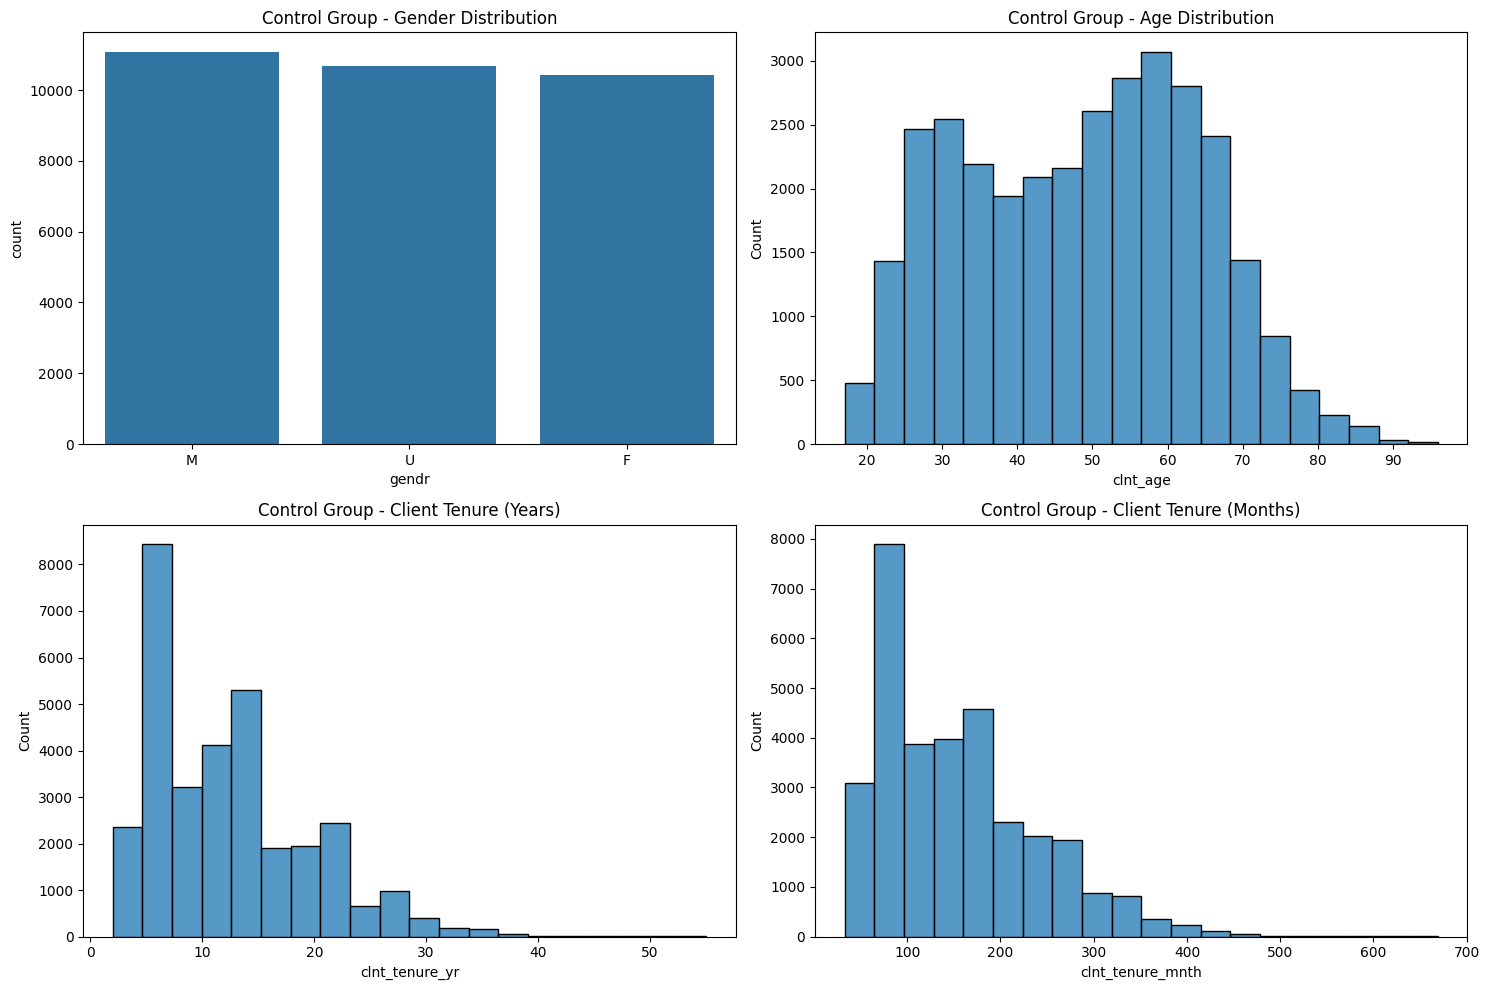

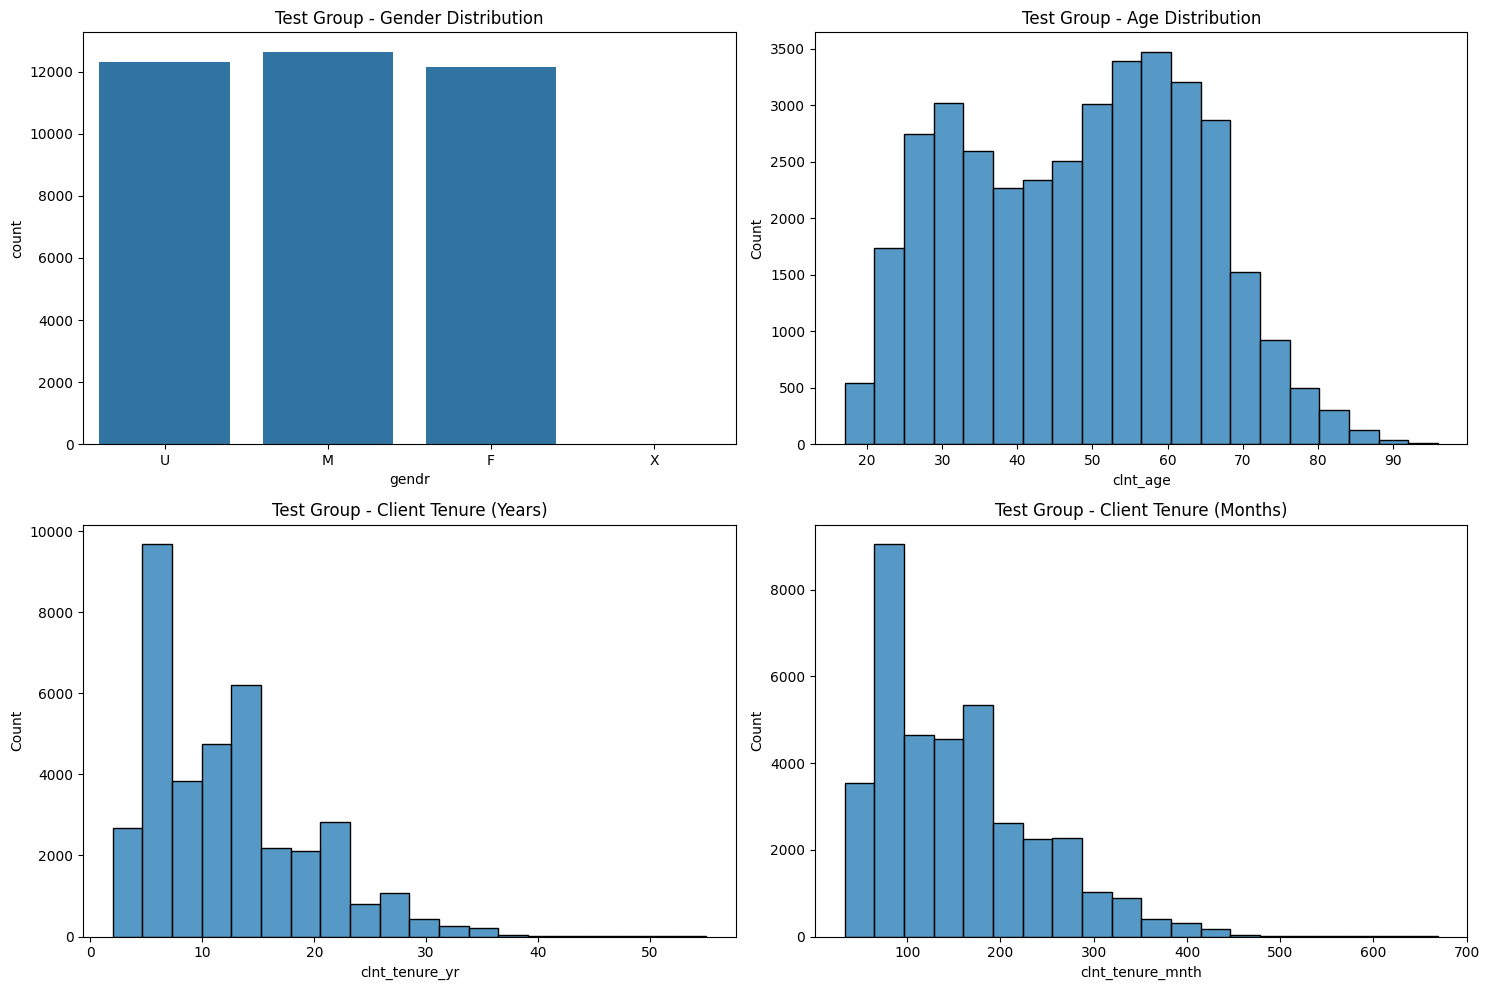

In [30]:

# Univariate Analysis - Demographics
def demographic_analysis(df, title):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.countplot(data=df, x='gendr')
    plt.title(f'{title} - Gender Distribution')

    plt.subplot(2, 2, 2)
    sns.histplot(data=df, x='clnt_age', bins=20)
    plt.title(f'{title} - Age Distribution')

    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='clnt_tenure_yr', bins=20)
    plt.title(f'{title} - Client Tenure (Years)')

    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='clnt_tenure_mnth', bins=20)
    plt.title(f'{title} - Client Tenure (Months)')

    plt.tight_layout()
    plt.show()

demographic_analysis(df_control_final, 'Control Group')
demographic_analysis(df_test_final, 'Test Group')


### Demographic side by side comparisson 

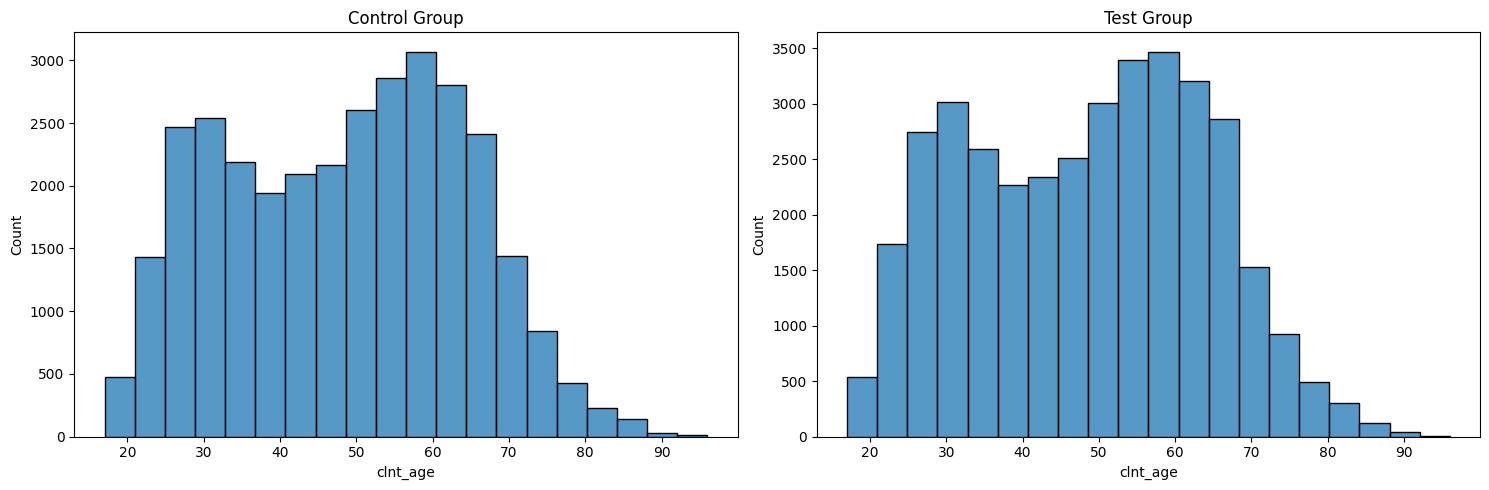

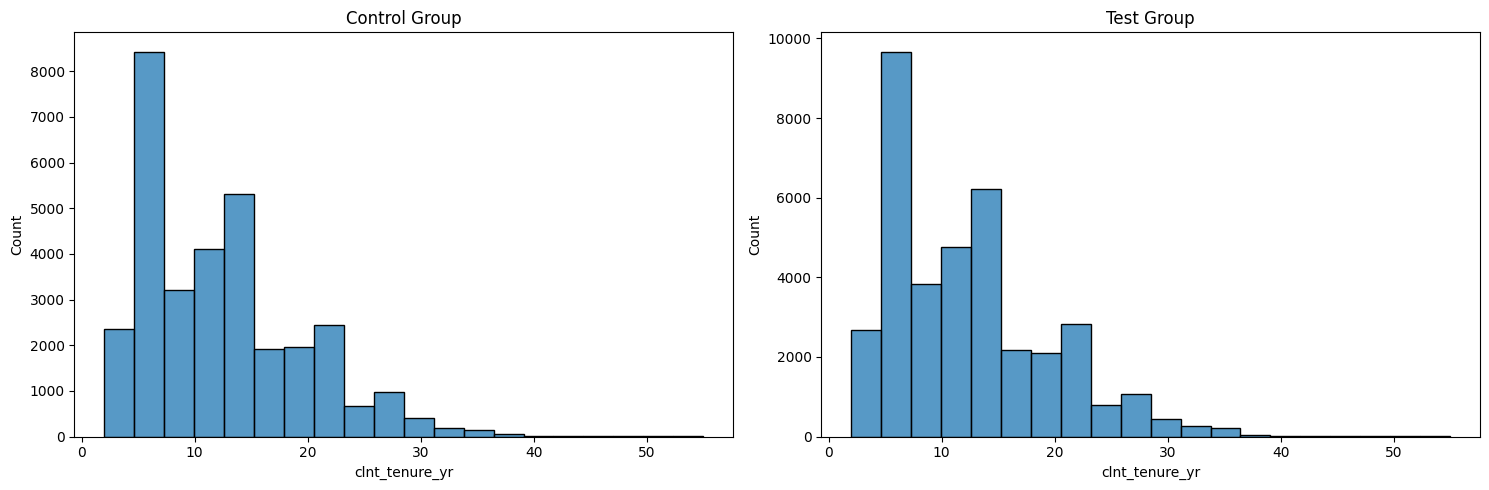

In [31]:
def visualize_side_by_side(df1, df2, title1, title2, col):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df1, x=col, bins=20)
    plt.title(title1)

    plt.subplot(1, 2, 2)
    sns.histplot(data=df2, x=col, bins=20)
    plt.title(title2)

    plt.tight_layout()
    plt.show()

visualize_side_by_side(df_control_final, df_test_final, 'Control Group', 'Test Group', 'clnt_age')
visualize_side_by_side(df_control_final, df_test_final, 'Control Group', 'Test Group', 'clnt_tenure_yr')

## 2. Client Behaviour Analysis


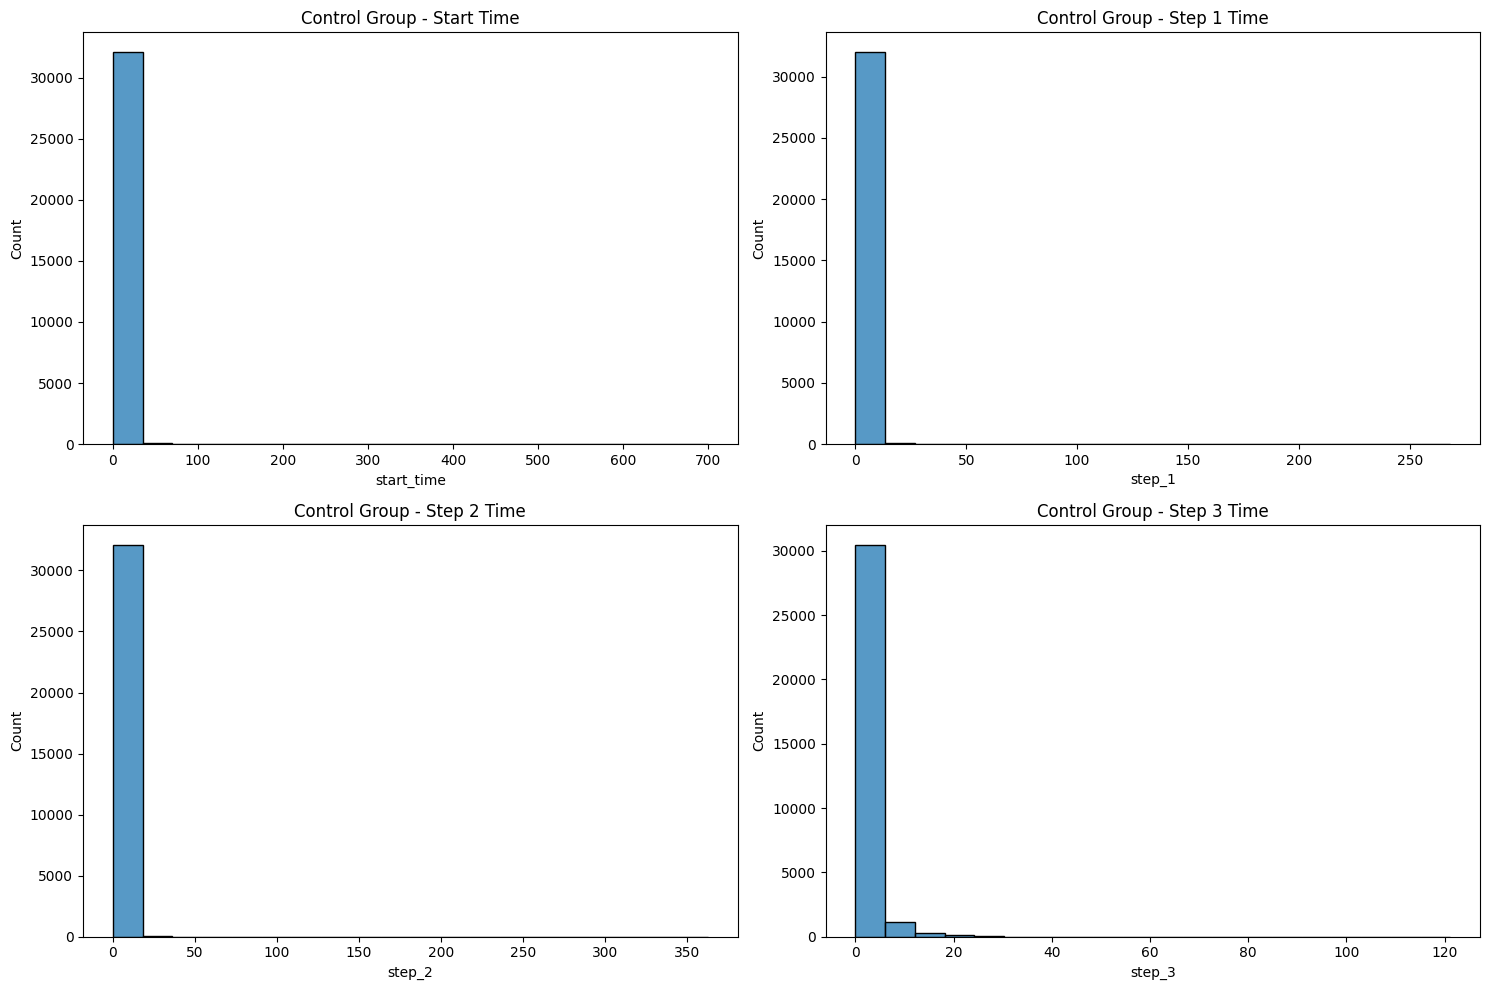

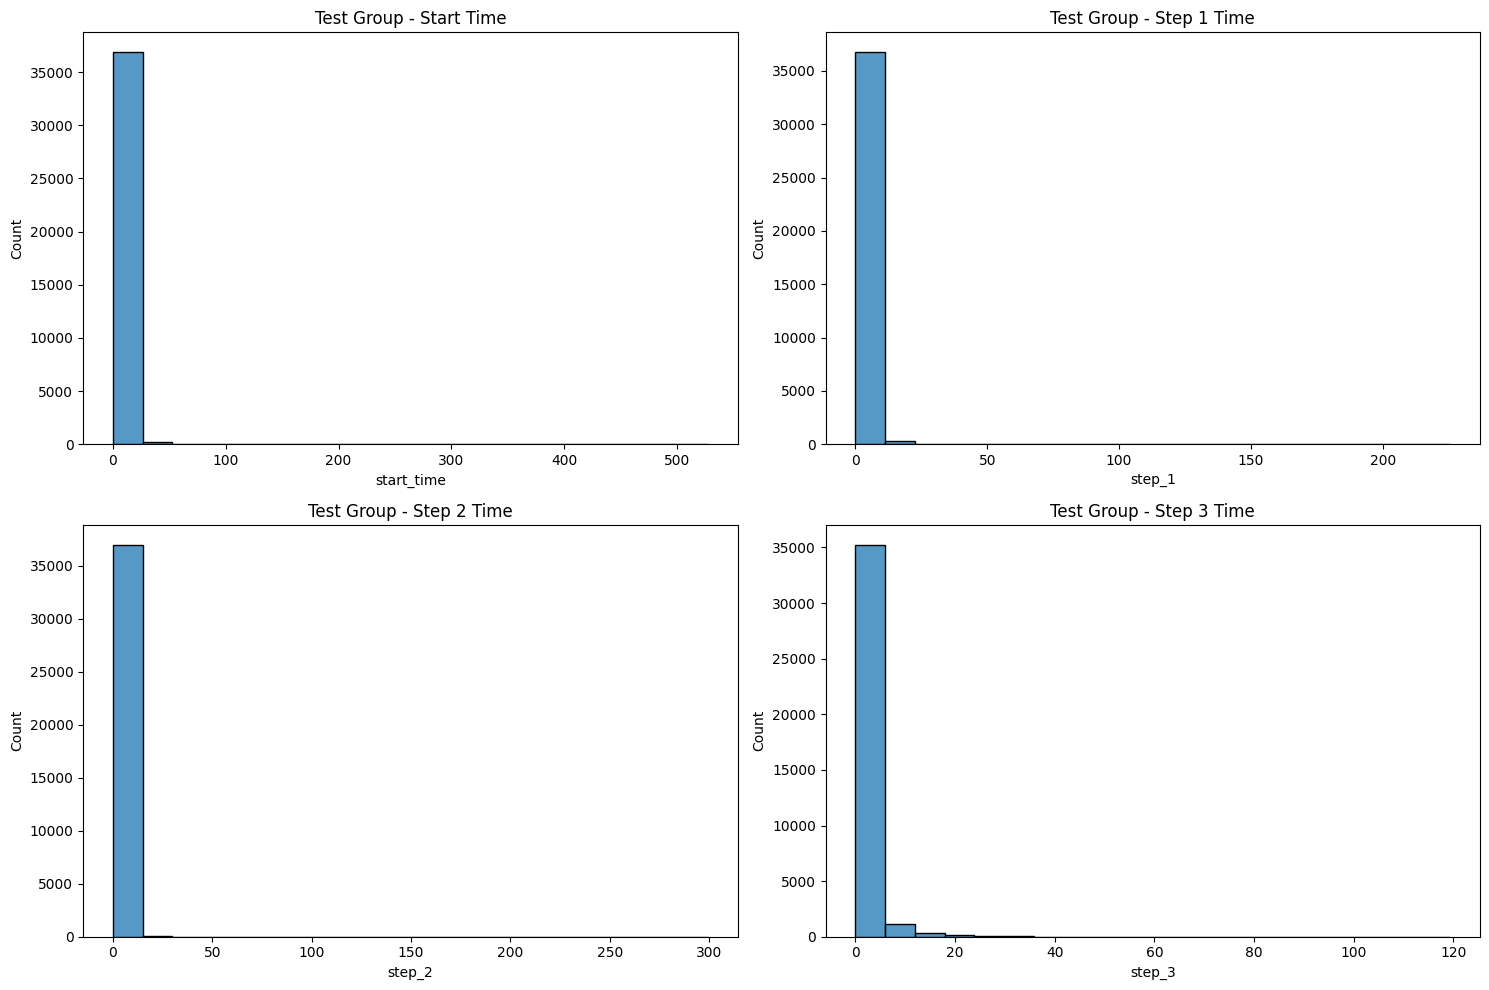

In [32]:
# Bivariate Analysis - Steps and Time
def behavior_analysis(df, title):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='start_time', bins=20)
    plt.title(f'{title} - Start Time')

    plt.subplot(2, 2, 2)
    sns.histplot(data=df, x='step_1', bins=20)
    plt.title(f'{title} - Step 1 Time')

    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='step_2', bins=20)
    plt.title(f'{title} - Step 2 Time')

    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='step_3', bins=20)
    plt.title(f'{title} - Step 3 Time')

    plt.tight_layout()
    plt.show()

behavior_analysis(df_control_final, 'Control Group')
behavior_analysis(df_test_final, 'Test Group')


## 3. Key Performance Indicators (KPIs)


Control Group KPIs: {'completion_rate': 0.47655448867344086, 'avg_start_time': np.float64(1.2335465025946986), 'avg_step_1_time': np.float64(0.6796180976352506), 'avg_step_2_time': np.float64(1.155185047077468), 'avg_step_3_time': np.float64(1.4375802492153755), 'error_rate': 0.7412137596718561}
Test Group KPIs: {'completion_rate': 0.5774203976078875, 'avg_start_time': np.float64(1.2768008189213946), 'avg_step_1_time': np.float64(0.9660513980927752), 'avg_step_2_time': np.float64(1.1766278756532513), 'avg_step_3_time': np.float64(1.3921830720327568), 'error_rate': 0.7265233554226604}


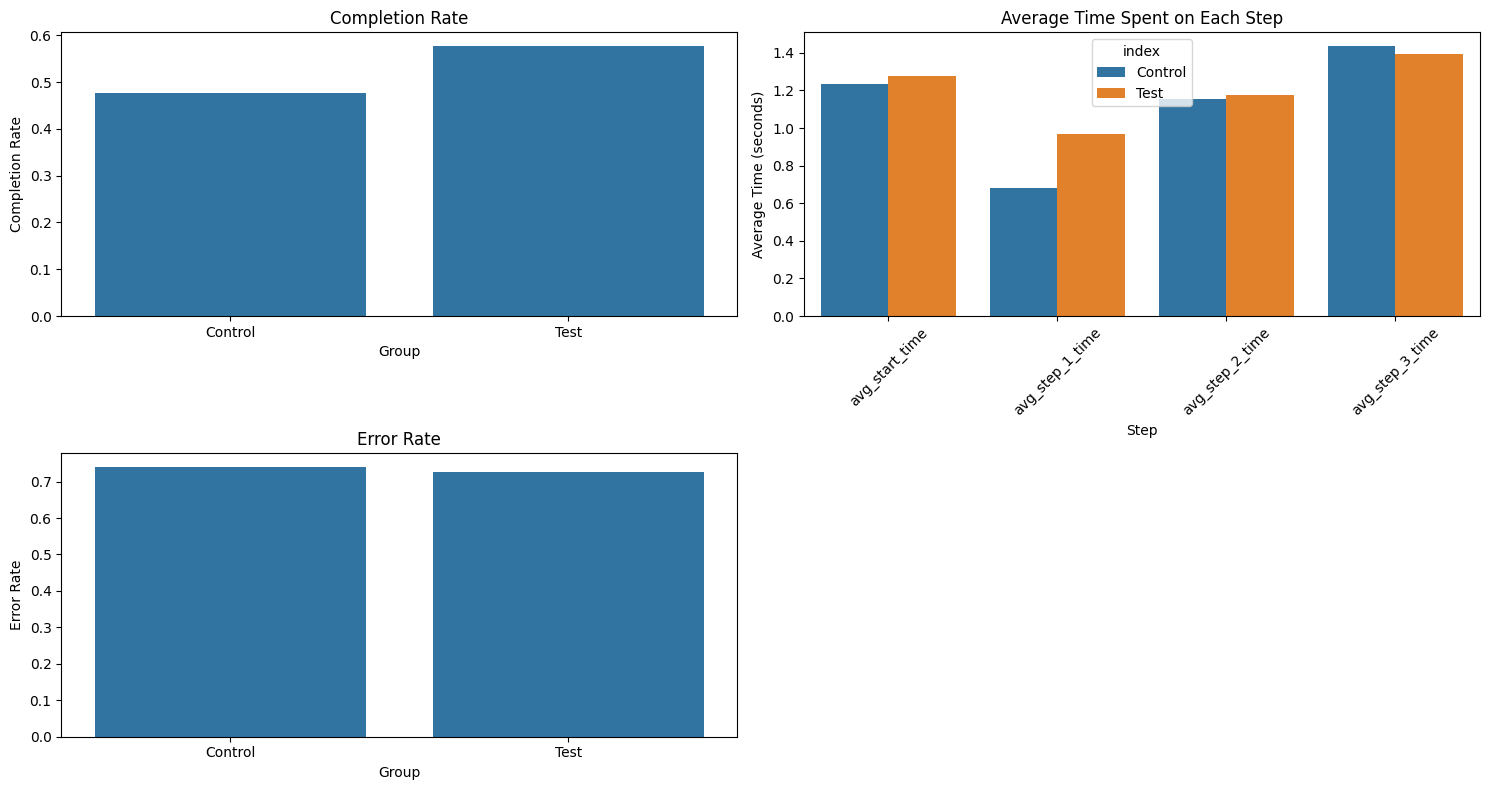

In [33]:

# Calculate KPIs
def calculate_kpis(df):
    kpis = {}

    # Completion Rate
    total_visits = df['visit_visitor_id'].nunique()
    completed_visits = df[df['last_step'] == 'confirm']['visit_visitor_id'].nunique()
    kpis['completion_rate'] = completed_visits / total_visits

    # Time Spent on Each Step
    kpis['avg_start_time'] = df['start_time'].mean()
    kpis['avg_step_1_time'] = df['step_1'].mean()
    kpis['avg_step_2_time'] = df['step_2'].mean()
    kpis['avg_step_3_time'] = df['step_3'].mean()

    # Error Rates
    errors = df[(df['step_1'] < df['start_time']) | (df['step_2'] < df['step_1']) | (df['step_3'] < df['step_2'])]
    kpis['error_rate'] = errors['visit_visitor_id'].nunique() / total_visits

    return kpis

kpis_control = calculate_kpis(df_control_final)
kpis_test = calculate_kpis(df_test_final)

print("Control Group KPIs:", kpis_control)
print("Test Group KPIs:", kpis_test)

# Convert KPIs to DataFrame for visualization
kpis_df = pd.DataFrame([kpis_control, kpis_test], index=['Control', 'Test']).reset_index()
kpis_df = kpis_df.melt(id_vars='index', var_name='KPI', value_name='Value')

# Visualization
plt.figure(figsize=(15, 8))

# Completion Rate
plt.subplot(2, 2, 1)
sns.barplot(data=kpis_df[kpis_df['KPI'] == 'completion_rate'], x='index', y='Value')
plt.title('Completion Rate')
plt.ylabel('Completion Rate')
plt.xlabel('Group')

# Average Time Spent on Each Step
plt.subplot(2, 2, 2)
sns.barplot(data=kpis_df[kpis_df['KPI'].str.contains('avg')], x='KPI', y='Value', hue='index')
plt.title('Average Time Spent on Each Step')
plt.ylabel('Average Time (seconds)')
plt.xlabel('Step')
plt.xticks(rotation=45)

# Error Rates
plt.subplot(2, 2, 3)
sns.barplot(data=kpis_df[kpis_df['KPI'] == 'error_rate'], x='index', y='Value')
plt.title('Error Rate')
plt.ylabel('Error Rate')
plt.xlabel('Group')

plt.tight_layout()
plt.show()


In [34]:
df_test_final.shape

(37122, 23)

In [35]:
df_control_final.shape

(32181, 23)

## 4. Hypothesis Testing

### 4.1. Completion Rate

Control Group KPIs: {'completion_rate': 0.47655448867344086, 'avg_start_time': np.float64(1.2335465025946986), 'avg_step_1_time': np.float64(0.6796180976352506), 'avg_step_2_time': np.float64(1.155185047077468), 'avg_step_3_time': np.float64(1.4375802492153755), 'error_rate': 0.7412137596718561}
Test Group KPIs: {'completion_rate': 0.5774203976078875, 'avg_start_time': np.float64(1.2768008189213946), 'avg_step_1_time': np.float64(0.9660513980927752), 'avg_step_2_time': np.float64(1.1766278756532513), 'avg_step_3_time': np.float64(1.3921830720327568), 'error_rate': 0.7265233554226604}
Chi-Squared Test p-value: 4.620759680288328e-155


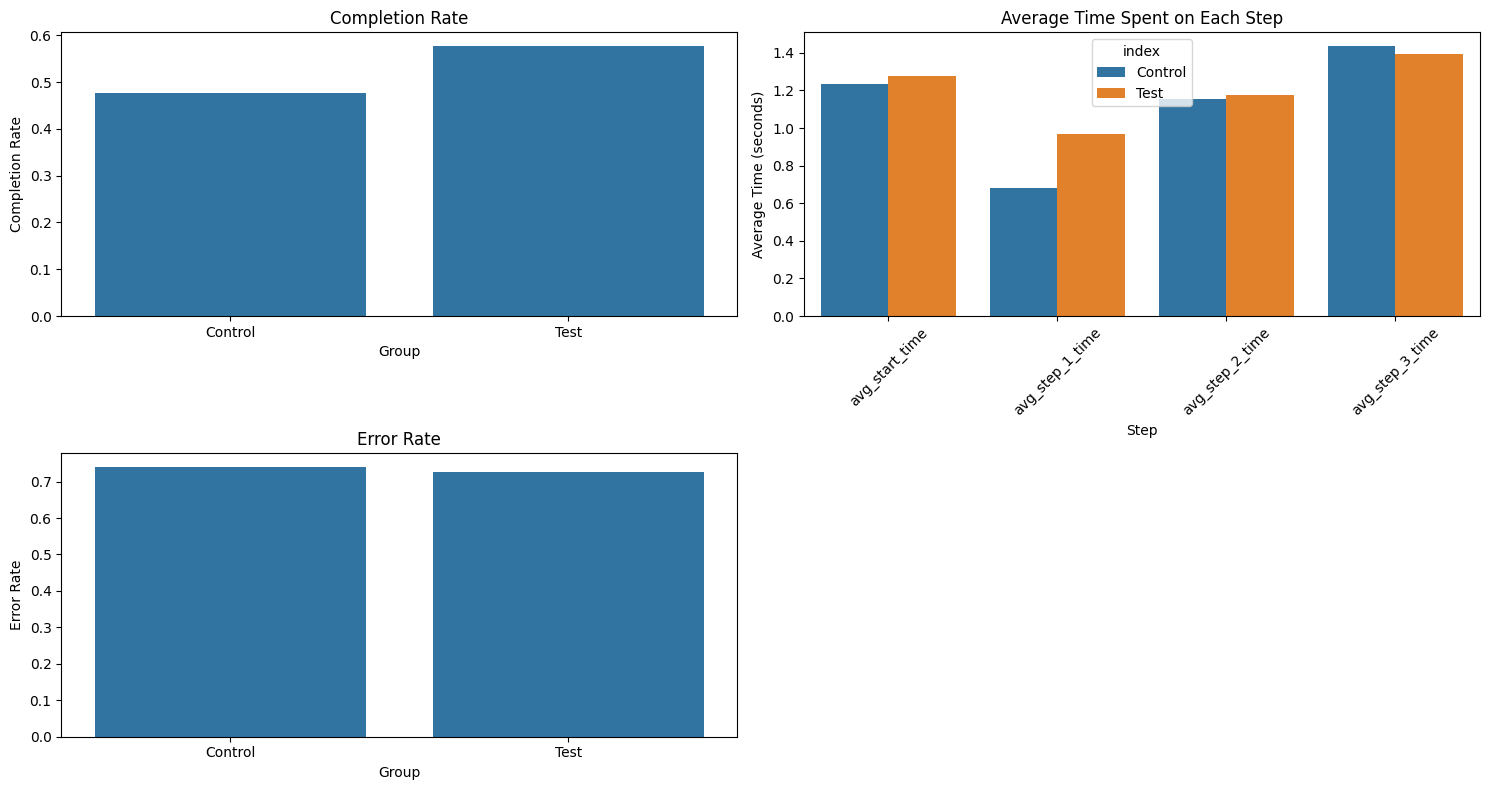

In [36]:

# Calculate KPIs
def calculate_kpis(df):
    kpis = {}
    total_visits = df['visit_visitor_id'].nunique()
    completed_visits = df[df['last_step'] == 'confirm']['visit_visitor_id'].nunique()
    
    # KPIs Calculation
    kpis['completion_rate'] = completed_visits / total_visits
    kpis['avg_start_time'] = df['start_time'].mean()
    kpis['avg_step_1_time'] = df['step_1'].mean()
    kpis['avg_step_2_time'] = df['step_2'].mean()
    kpis['avg_step_3_time'] = df['step_3'].mean()

    errors = df[(df['step_1'] < df['start_time']) | (df['step_2'] < df['step_1']) | (df['step_3'] < df['step_2'])]

    kpis['error_rate'] = errors['visit_visitor_id'].nunique() / total_visits
    
    return kpis, total_visits, completed_visits

kpis_control, total_visits_control, completed_visits_control = calculate_kpis(df_control_final)
kpis_test, total_visits_test, completed_visits_test = calculate_kpis(df_test_final)

print("Control Group KPIs:", kpis_control)
print("Test Group KPIs:", kpis_test)

# Chi-Squared Test for Completion Rate
contingency_table = pd.DataFrame({
    'Completed': [completed_visits_control, completed_visits_test],
    'Not Completed': [total_visits_control - completed_visits_control, total_visits_test - completed_visits_test]
}, index=['Control', 'Test'])

chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-Squared Test p-value:", p)

# Convert KPIs to DataFrame for visualization
kpis_df = pd.DataFrame([kpis_control, kpis_test], index=['Control', 'Test']).reset_index()
kpis_df = kpis_df.melt(id_vars='index', var_name='KPI', value_name='Value')

# Visualization
plt.figure(figsize=(15, 8))

# Completion Rate
plt.subplot(2, 2, 1)
sns.barplot(data=kpis_df[kpis_df['KPI'] == 'completion_rate'], x='index', y='Value')
plt.title('Completion Rate')
plt.ylabel('Completion Rate')
plt.xlabel('Group')

# Average Time Spent on Each Step
plt.subplot(2, 2, 2)
sns.barplot(data=kpis_df[kpis_df['KPI'].str.contains('avg')], x='KPI', y='Value', hue='index')
plt.title('Average Time Spent on Each Step')
plt.ylabel('Average Time (seconds)')
plt.xlabel('Step')
plt.xticks(rotation=45)

# Error Rates
plt.subplot(2, 2, 3)
sns.barplot(data=kpis_df[kpis_df['KPI'] == 'error_rate'], x='index', y='Value')
plt.title('Error Rate')
plt.ylabel('Error Rate')
plt.xlabel('Group')

plt.tight_layout()
plt.show()


In [37]:
# df_control_final and df_control_test should be defined with the columns mentioned in the problem statement
# Calculate KPIs for control and test groups

kpis_control = calculate_kpis(df_control_final)
print("Control Group KPIs:", kpis_control)



Control Group KPIs: ({'completion_rate': 0.47655448867344086, 'avg_start_time': np.float64(1.2335465025946986), 'avg_step_1_time': np.float64(0.6796180976352506), 'avg_step_2_time': np.float64(1.155185047077468), 'avg_step_3_time': np.float64(1.4375802492153755), 'error_rate': 0.7412137596718561}, 32181, 15336)


In [38]:
kpis_test = calculate_kpis(df_test_final)
print("Test Group KPIs:", kpis_test)

Test Group KPIs: ({'completion_rate': 0.5774203976078875, 'avg_start_time': np.float64(1.2768008189213946), 'avg_step_1_time': np.float64(0.9660513980927752), 'avg_step_2_time': np.float64(1.1766278756532513), 'avg_step_3_time': np.float64(1.3921830720327568), 'error_rate': 0.7265233554226604}, 37122, 21435)


### 4.2. Cost-Effectiveness Threshold

In [39]:
# Cost-Effectiveness Analysis
#completion_rate_increase = kpis_df.loc[kpis_df['KPI']=='Completion Rate', 'Test'].iloc[0] - kpis_df.loc[kpis_df['KPI']=='Completion Rate', 'Control'].iloc[0]
#3print("Completion Rate Increase:", completion_rate_increase)

# Check if the completion rate increase meets the cost-effectiveness threshold
#threshold = 0.05

#if completion_rate_increase >= threshold:
 #   print("The new design meets the cost-effectiveness threshold.")
#else:
#    print("The new design does not meet the cost-effectiveness threshold.")

### 4.3. Other Hypothesis Testing

In [40]:


# Average Age Hypothesis Test
t_stat_age, p_value_age = ttest_ind(df_control_final['clnt_age'], df_test_final['clnt_age'])
print("Average Age t-test p-value:", p_value_age)

# Client Tenure Hypothesis Test
t_stat_tenure, p_value_tenure = ttest_ind(df_control_final['clnt_tenure_yr'], df_test_final['clnt_tenure_yr'])
print("Client Tenure t-test p-value:", p_value_tenure)

# Gender Difference Hypothesis Test
gender_counts_control = df_control_final['gendr'].value_counts()
gender_counts_test = df_test_final['gendr'].value_counts()

# Create a contingency table
contingency_table = pd.DataFrame([gender_counts_control, gender_counts_test], index=['Control', 'Test'])

chi2, p, _, _ = chi2_contingency(contingency_table)
print("Gender Difference Chi-Squared Test p-value:", p)



Average Age t-test p-value: 0.187777141948715
Client Tenure t-test p-value: 0.9027165181664574
Gender Difference Chi-Squared Test p-value: nan


## 5. Experiment Evaluation


Control Group Size: 32181
Test Group Size: 37122


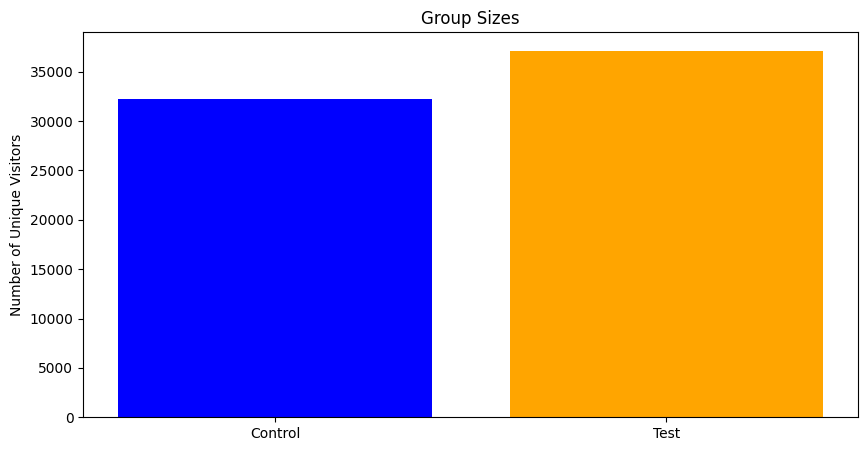

Gender Distribution Control:
 gendr
M    0.344209
U    0.331842
F    0.323949
Name: proportion, dtype: float64
Gender Distribution Test:
 gendr
M    0.340553
U    0.331528
F    0.327865
X    0.000054
Name: proportion, dtype: float64


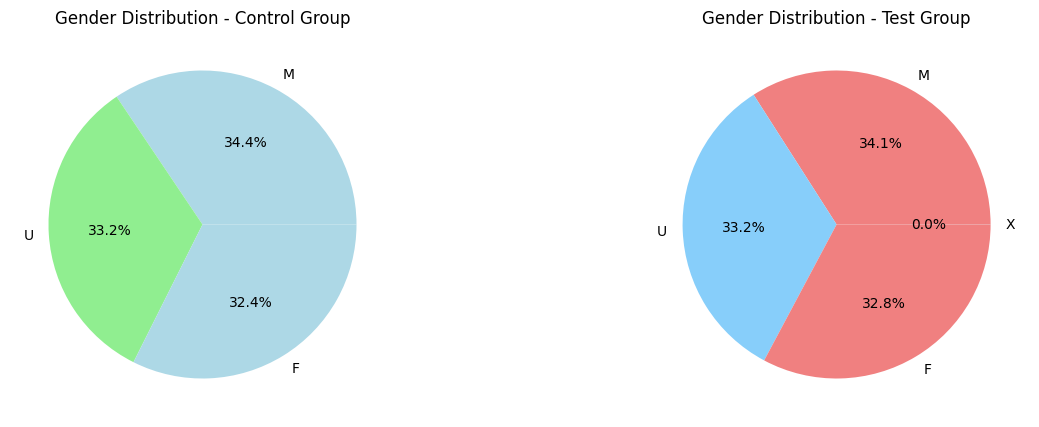

In [41]:


# Experiment Design Evaluation with Visualizations
def experiment_evaluation_with_visualizations(df_control, df_test):
    control_size = df_control['visit_visitor_id'].nunique()
    test_size = df_test['visit_visitor_id'].nunique()

    print("Control Group Size:", control_size)
    print("Test Group Size:", test_size)

    # Plot Group Sizes
    plt.figure(figsize=(10, 5))
    plt.bar(['Control', 'Test'], [control_size, test_size], color=['blue', 'orange'])
    plt.title('Group Sizes')
    plt.ylabel('Number of Unique Visitors')
    plt.show()

    # Gender Distribution
    gender_dist_control = df_control['gendr'].value_counts(normalize=True)
    gender_dist_test = df_test['gendr'].value_counts(normalize=True)

    print("Gender Distribution Control:\n", gender_dist_control)
    print("Gender Distribution Test:\n", gender_dist_test)

    # Plot Gender Distribution
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].pie(gender_dist_control, labels=gender_dist_control.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
    axs[0].set_title('Gender Distribution - Control Group')

    axs[1].pie(gender_dist_test, labels=gender_dist_test.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
    axs[1].set_title('Gender Distribution - Test Group')

    plt.show()

experiment_evaluation_with_visualizations(df_control_final, df_test_final)


In [42]:
# Additional Data Needs
print("Additional data that could enhance the analysis:")
print("- Detailed logs of user interactions (e.g., clicks, hovers)")
print("- Feedback or survey data on user satisfaction")
print("- Data on external factors that could influence user behavior (e.g., marketing campaigns)")


Additional data that could enhance the analysis:
- Detailed logs of user interactions (e.g., clicks, hovers)
- Feedback or survey data on user satisfaction
- Data on external factors that could influence user behavior (e.g., marketing campaigns)
